<a href="https://colab.research.google.com/github/mathjams/machine-learning-basics/blob/main/content_based_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from recsysNN_utils import *
pd.set_option("display.precision", 1)

Let $r(i,j)=0,1$ denote whether user $j$ rated movie $i$ and let $y(i,j)$ denote the rating given.

Every user has a set of parameters $\vec{w}^{(j)}$, corresponding to the features. For example, if the feature if a vector [romance factor, action factor], a personal set of parameters $[0,1]$ could mean that the user hates romance movies but loves action ones. We can combine the vectors $\vec{w}^{(j)}$ to become $W$ (like in a neural network). Each user also has a scalar parameter $b^{(j)}$, to add on (like a linear regression). Putting these scalar parameters we can make a vector $\vec{b}$ to represent all the parameters for the users.

Now, every movie also has a set of features and the ratings for those features. We can denote them as $\vec{x}^{(i)}$, and put them together into a matrix $X$. Alos, put the matrix of $r(i,j)$ into matrix $R$.


$$\mathbf{X} =
\begin{bmatrix}
--- (\mathbf{x}^{(0)})^T --- \\
--- (\mathbf{x}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{x}^{(n_m-1)})^T --- \\
\end{bmatrix} , \quad
\mathbf{W} =
\begin{bmatrix}
--- (\mathbf{w}^{(0)})^T --- \\
--- (\mathbf{w}^{(1)})^T --- \\
\vdots \\
--- (\mathbf{w}^{(n_u-1)})^T --- \\
\end{bmatrix},\quad
\mathbf{ b} =
\begin{bmatrix}
 b^{(0)}  \\
 b^{(1)} \\
\vdots \\
b^{(n_u-1)} \\
\end{bmatrix}\quad
$$


What we want our model to do is figure out what the features should be, and the feature values, along with what the personal paramaters should be in order to minimize the cost. Our prediction is basically $\hat{y}=\vec{w}^{(j)}\cdot \vec{x}^{(i)}+b^{(j)}.$

The collaborative filtering cost function is given by
$$J({\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},\mathbf{w}^{(0)},b^{(0)},...,\mathbf{w}^{(n_u-1)},b^{(n_u-1)}})= \left[ \frac{1}{2}\sum_{(i,j):r(i,j)=1}(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+ \underbrace{\left[
\frac{\lambda}{2}
\sum_{j=0}^{n_u-1}\sum_{k=0}^{n-1}(\mathbf{w}^{(j)}_k)^2
+ \frac{\lambda}{2}\sum_{i=0}^{n_m-1}\sum_{k=0}^{n-1}(\mathbf{x}_k^{(i)})^2
\right]}_{regularization}
\tag{1}$$
The first summation in (1) is "for all $i$, $j$ where $r(i,j)$ equals $1$" and could be written:

$$
= \left[ \frac{1}{2}\sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+\text{regularization}
$$


In [ ]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    nm, nu = Y.shape
    n=X.shape[1]
    J = 0
    for i in range(nm):
        for j in range(nu):
            J+=1/2*(R[i][j]*(np.dot(W[j],X[i])+b[0][j]-Y[i][j])**2)
    for k in range(n):
        for j in range(nu):
            J+=lambda_/2*W[j][k]**2
    for k in range(n):
        for i in range(nm):
            J+=lambda_/2*X[i][k]**2
    return J

Vectorized version:

In [ ]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

Now, we can take some ratings and input it into our model

In [ ]:
movieList, movieList_df = load_Movie_List_pd()

my_ratings = np.zeros(num_movies)          #  Initialize my ratings

# Check the file small_movie_list.csv for id of each movie in our dataset
# For example, Toy Story 3 (2010) has ID 2700, so to rate it "5", you can set
my_ratings[2700] = 5

#Or suppose you did not enjoy Persuasion (2007), you can set
my_ratings[2609] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[929]  = 5   # Lord of the Rings: The Return of the King, The
my_ratings[246]  = 5   # Shrek (2001)
my_ratings[2716] = 3   # Inception
my_ratings[1150] = 5   # Incredibles, The (2004)
my_ratings[382]  = 2   # Amelie (Fabuleux destin d'Amélie Poulain, Le)
my_ratings[366]  = 5   # Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
my_ratings[622]  = 5   # Harry Potter and the Chamber of Secrets (2002)
my_ratings[988]  = 3   # Eternal Sunshine of the Spotless Mind (2004)
my_ratings[2925] = 1   # Louis Theroux: Law & Disorder (2008)
my_ratings[2937] = 1   # Nothing to Declare (Rien à déclarer)
my_ratings[793]  = 5   # Pirates of the Caribbean: The Curse of the Black Pearl (2003)
my_rated = [i for i in range(len(my_ratings)) if my_ratings[i] > 0]

print('\nNew user ratings:\n')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0 :
        print(f'Rated {my_ratings[i]} for  {movieList_df.loc[i,"title"]}');

In [ ]:
# Reload ratings
Y, R = load_ratings_small()

# Add new user ratings to Y
Y = np.c_[my_ratings, Y]

# Add new user indicator matrix to R
R = np.c_[(my_ratings != 0).astype(int), R]

# Normalize the Dataset
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 100

# Set Initial Parameters (W, X), use tf.Variable to track these variables
tf.random.set_seed(1234) # for consistent results
W = tf.Variable(tf.random.normal((num_users,  num_features),dtype=tf.float64),  name='W')
X = tf.Variable(tf.random.normal((num_movies, num_features),dtype=tf.float64),  name='X')
b = tf.Variable(tf.random.normal((1,          num_users),   dtype=tf.float64),  name='b')

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate=1e-1)

In [ ]:
iterations = 200
lambda_ = 1
for iter in range(iterations):
    # Use TensorFlow’s GradientTape
    # to record the operations used to compute the cost
    with tf.GradientTape() as tape:

        # Compute the cost (forward pass included in cost)
        cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss
    grads = tape.gradient( cost_value, [X,W,b] )

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    #updates the training variables using Adam
    optimizer.apply_gradients( zip(grads, [X,W,b]) )

    # Log periodically.
    if iter % 20 == 0:
        print(f"Training loss at iteration {iter}: {cost_value:0.1f}")

In [ ]:
# Make a prediction using trained weights and biases
p = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

#restore the mean, since we normalized before
pm = p + Ymean

my_predictions = pm[:,0]


The problem is, we may have differently sized $\vec{w}$ and $\vec{x}$, because they can depend on different things. Thus, instead we can a neural network to process $\vec{x}_u, \vec{x}_m$ of features for the user and movie into $\vec{v}_u, \vec{v}_m$ of the same size, and then we can take the dot product to find the predicted rating.

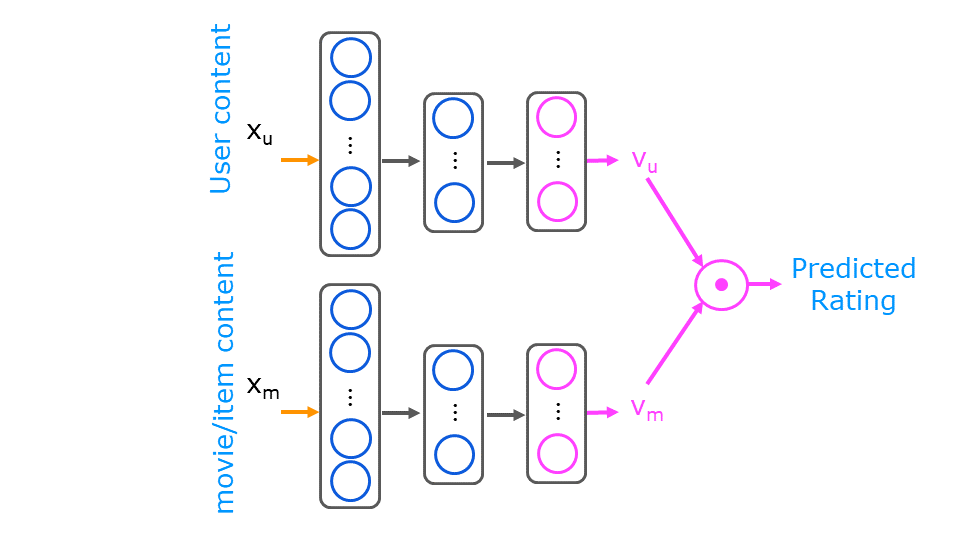

We can use any layers, as long as the last dense layer is of the same size.

In [ ]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

Below is an example of a neural network that accomplishes this.

In [ ]:
from tensorflow.keras.layers import Dense
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    Dense(units=256, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=num_outputs, activation="linear")

])

item_NN = tf.keras.models.Sequential([
    Dense(units=256, activation="relu"),
    Dense(units=128, activation="relu"),
    Dense(units=num_outputs, activation="linear")
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=3

Making a prediction

In [ ]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_movies(sorted_ypu, sorted_items, movie_dict, maxcount = 10)

We can also find similar items using the distance between the resulting $\vec{v}_m$s to gauge how similar the two movies are, such as $$\left\Vert \mathbf{v_m^{(k)}} - \mathbf{v_m^{(i)}}  \right\Vert^2 = \sum_{l=1}^{n}(v_{m_l}^{(k)} - v_{m_l}^{(i)})^2\tag{1}.$$

We can even use our model from before to generate $\vec{v}_m$ for our movies, and so we can even sort new movies without retraining.

In [ ]:
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    d=(np.linalg.norm(a-b))**2
    return d

In [ ]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)                        # incorporate normalization as was done in the original model
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()